In [3]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as stats
from sklearn.linear_model import LinearRegression 
from sklearn.decomposition import PCA
import scipy
import statsmodels.api as sm
import pandas as pd
from statsmodels.tsa.stattools import coint, grangercausalitytests 
import matplotlib
from itertools import groupby, count 
import pickle
import yfinance as yf
from dateutil.parser import parse 
import datetime
from scipy.optimize import brentq 
import traceback
import quantstats as qs 
%matplotlib inline
# Allow Multiple Outputs in Cells
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"
# Disable Warnings
import warnings 
warnings.filterwarnings('ignore')

In [6]:
# Download Stocks
stocks = yf.download('SPY,QQQ', start='2020-1-1', progress=False).Close 
stocks.head()

Ticker,QQQ,SPY
Date,,
2020-01-02,216.160004,324.869995
2020-01-03,214.179993,322.410004
2020-01-06,215.559998,323.640015
2020-01-07,215.529999,322.730011
2020-01-08,217.149994,324.450012


<Axes: xlabel='Date'>

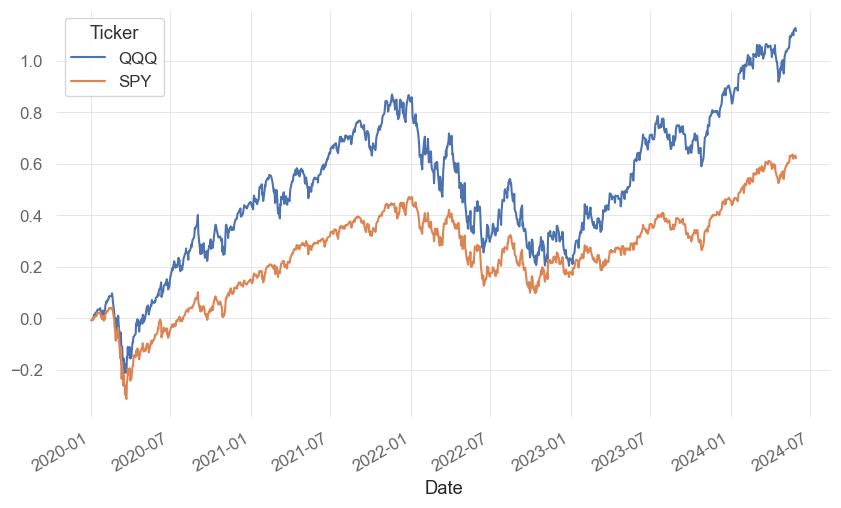

In [7]:
# Equity Curve: PROD(1+R)-1
stocks.pct_change().add(1).cumprod().add(-1).plot()

<Axes: xlabel='Date'>

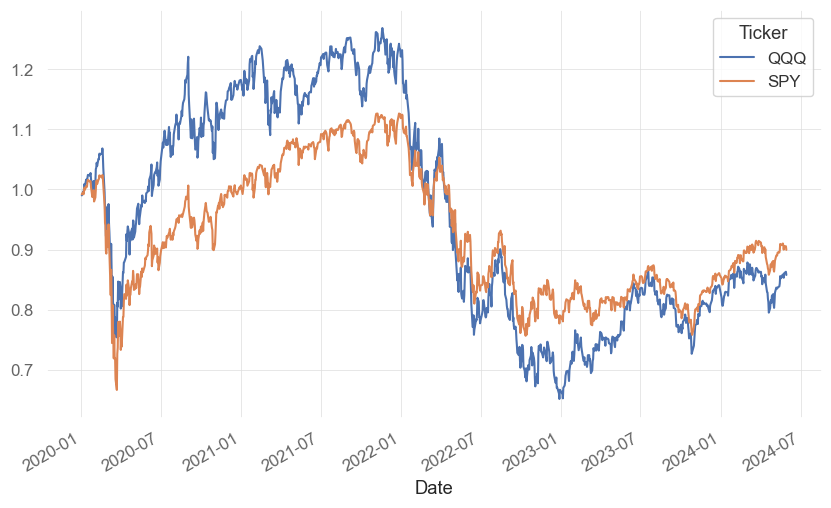

In [9]:
# Equity Curve of Centered Data i.e. with mean return removed
centered_returns = stocks.pct_change().dropna() - stocks.pct_change().mean()
centered_returns.add(1).cumprod().plot()



In [11]:
# Covariance of Centered Returns
S = centered_returns.cov() 
print(S)

Ticker       QQQ       SPY
Ticker                    
QQQ     0.000276  0.000213
SPY     0.000213  0.000190


In [14]:
# Calculate Eigenvalues and Eigenvectors of Covariance Matrix
E = np.linalg.eig(S)
# EigenValues
print('EigenValues') 
eValues=E[0] 
eValues
# EigenVectors
print('EigenVectors')
eVectors=E[1]
eVectors

EigenValues


array([4.50405402e-04, 1.59982901e-05])

EigenVectors


array([[ 0.77373608, -0.63350807],
       [ 0.63350807,  0.77373608]])

Text(0.5, 0, 'R0 Values')

Text(0, 0.5, 'R1 Values')

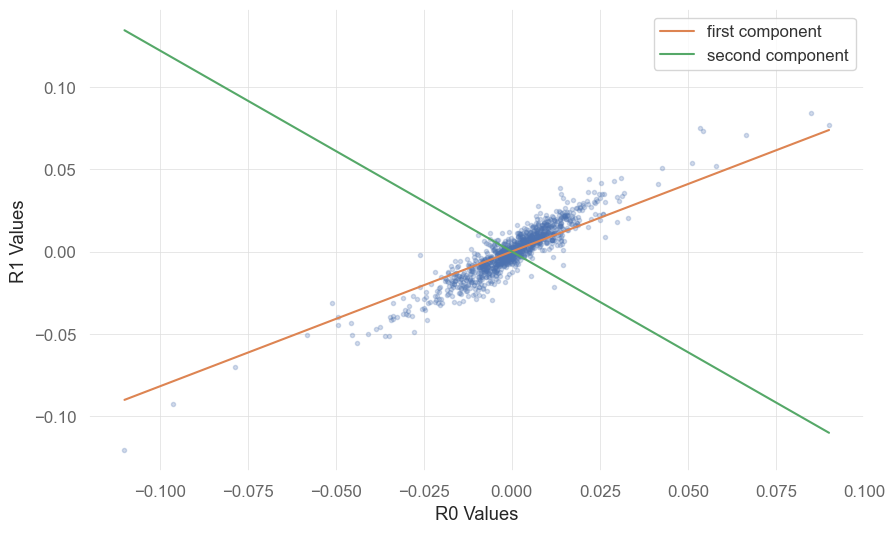

In [15]:
# Plot the Correlation of Stock Centered Returns
# 1. Compute Data for Principal Component Lines
x_axis = np.linspace(np.nanmin(centered_returns.SPY), np.nanmax(centered_returns.SPY))

dx1 = eVectors[0,0] 
dy1 = eVectors[1,0] 
slope1 = dy1/dx1

dx2 = eVectors[0,1] 
dy2 = eVectors[1,1] 
slope2 = dy2/dx2

y_axis1 = slope1 * x_axis 
y_axis2 = slope2 * x_axis

# 2. Plot Centered Return Correlation Between X and Y
plt.plot(centered_returns.SPY, centered_returns.QQQ, '.', alpha=0.25)
# 3. Plot Principal Components
plt.plot(x_axis, y_axis1, label='first component') 
plt.plot(x_axis, y_axis2, label='second component')
plt.legend()
plt.xlabel('R0 Values')
plt.ylabel('R1 Values')
plt.show()

In [20]:
# Downloading More Instruments
import datetime
equities = yf.download('GOOG,AMZN,NFLX,BAC,JPM,WFC', start='2020-1-1', progress=False)

In [23]:
def pca(assets):
    x = assets.pct_change().dropna()
    p = np.linalg.eig((x-x.mean()).cov()) 
    evalues = p[0]
    evectors = p[1]

    
    return np.sort(evalues/sum(evalues))[::-1], evectors[:, np.argsort(evectors)]

Text(0.5, 1.0, 'Number of Principal Components vs Explained Variance')

Text(0.5, 0, 'Number of Components')

Text(0, 0.5, 'Explained Variance')

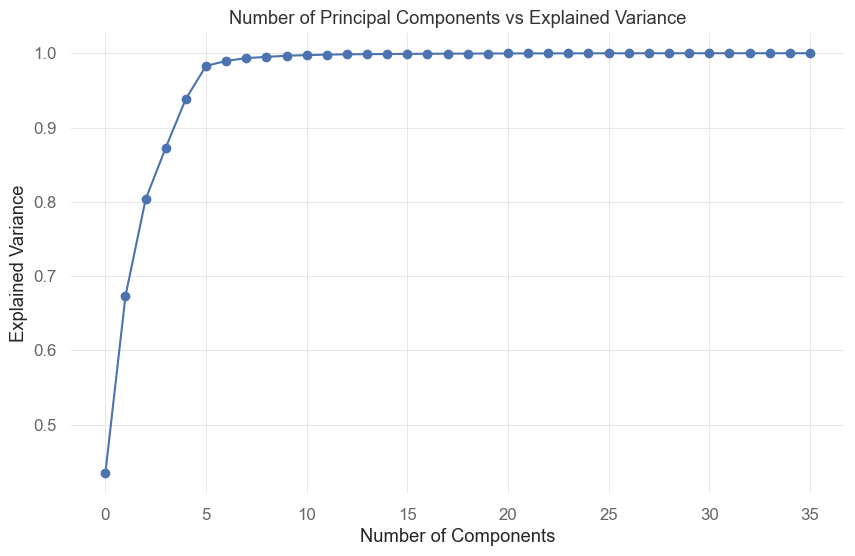

In [24]:
evalues, evectors = pca(equities)
plt.plot(np.cumsum(evalues), '-o')
plt.title('Number of Principal Components vs Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

In [35]:
# Define our Assets
tech_stocks = yf.download('GOOG,AMZN,NFLX', start='2020-1-1', progress=False)
bank_stocks = yf.download('BAC,JPM,WFC', start='2020-1-1', progress=False)
commodities = yf.download('CL=F,RB=F,GC=F', start='2020-1-1', progress=False)
bonds = yf.download('TLT,IEF,SHY', start='2020-1-1',progress=False)
currencies = yf.download('EURUSD=X,USDJPY=X,GBPUSD=X',progress=False)
tech_stocks.head()
tech_stocks.info()

Price       Adj Close                             Close             \
Ticker           AMZN       GOOG        NFLX       AMZN       GOOG   
Date                                                                 
2020-01-02  94.900497  68.368500  329.809998  94.900497  68.368500   
2020-01-03  93.748497  68.032997  325.899994  93.748497  68.032997   
2020-01-06  95.143997  69.710503  335.829987  95.143997  69.710503   
2020-01-07  95.343002  69.667000  330.750000  95.343002  69.667000   
2020-01-08  94.598503  70.216003  339.260010  94.598503  70.216003   

Price                        High                               Low  \
Ticker            NFLX       AMZN       GOOG        NFLX       AMZN   
Date                                                                  
2020-01-02  329.809998  94.900497  68.406998  329.980011  93.207497   
2020-01-03  325.899994  94.309998  68.625000  329.859985  93.224998   
2020-01-06  335.829987  95.184502  69.824997  336.359985  93.000000   
2020-01-07  330.750000  95.694504  70.149498  336.700012  94.601997   
2020-01-08  339.260010  95.550003  70.579002  342.700012  94.321999   

Price                                   Open                           Volume  \
Ticker           GOOG        NFLX       AMZN       GOOG        NFLX      AMZN   
Date                                                                            
2020-01-02  67.077499  324.779999  93.750000  67.077499  326.100006  80580000   
2020-01-03  67.277199  325.529999  93.224998  67.392998  326.779999  75288000   
2020-01-06  67.500000  321.200012  93.000000  67.500000  323.119995  81236000   
2020-01-07  69.518997  330.299988  95.224998  69.897003  336.470001  80898000   
2020-01-08  69.542000  331.049988  94.902000  69.603996  331.489990  70160000   

Price                          
Ticker          GOOG     NFLX  
Date                           
2020-01-02  28132000  4485800  
2020-01-03  23728000  3806900  
2020-01-06  34646000  5663100  
2020-01-07  30054000  4703200  
2020-01-08  30560000  7104500

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1109 entries, 2020-01-02 to 2024-05-29
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AMZN)  1109 non-null   float64
 1   (Adj Close, GOOG)  1109 non-null   float64
 2   (Adj Close, NFLX)  1109 non-null   float64
 3   (Close, AMZN)      1109 non-null   float64
 4   (Close, GOOG)      1109 non-null   float64
 5   (Close, NFLX)      1109 non-null   float64
 6   (High, AMZN)       1109 non-null   float64
 7   (High, GOOG)       1109 non-null   float64
 8   (High, NFLX)       1109 non-null   float64
 9   (Low, AMZN)        1109 non-null   float64
 10  (Low, GOOG)        1109 non-null   float64
 11  (Low, NFLX)        1109 non-null   float64
 12  (Open, AMZN)       1109 non-null   float64
 13  (Open, GOOG)       1109 non-null   float64
 14  (Open, NFLX)       1109 non-null   float64
 15  (Volume, AMZN)     1109 non-null   int64  
 16  (Volum

Text(0.5, 1.0, 'Factor Groupings')

Text(0.5, 0, 'First Component')

Text(0, 0.5, 'Second Component')

(-1.0999998901914063,
 1.0999976940195335,
 -1.0999993960525691,
 1.0999993960525691)

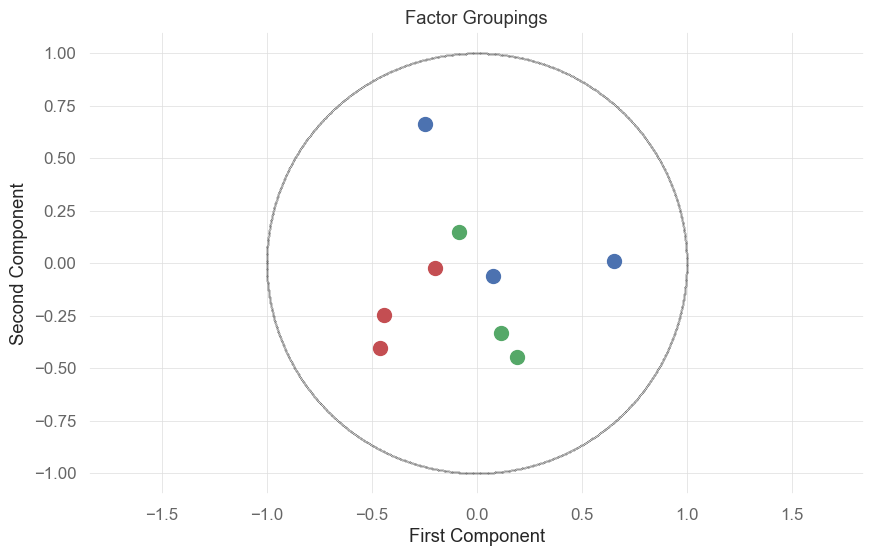

In [36]:
# Factor Analysis
r = []
lookback = 50

# Collect percentage changes for the lookback period
r.append(tech_stocks[('Adj Close', 'GOOG')].pct_change().iloc[-lookback:].values)
r.append(tech_stocks[('Adj Close', 'AMZN')].pct_change().iloc[-lookback:].values)
r.append(tech_stocks[('Adj Close', 'NFLX')].pct_change().iloc[-lookback:].values)
r.append(bank_stocks[('Adj Close', 'BAC')].pct_change().iloc[-lookback:].values)
r.append(bank_stocks[('Adj Close', 'JPM')].pct_change().iloc[-lookback:].values)
r.append(bank_stocks[('Adj Close', 'WFC')].pct_change().iloc[-lookback:].values)
r.append(commodities[('Adj Close', 'CL=F')].pct_change().iloc[-lookback:].values)
r.append(commodities[('Adj Close', 'RB=F')].pct_change().iloc[-lookback:].values)
r.append(commodities[('Adj Close', 'GC=F')].pct_change().iloc[-lookback:].values)


R = np.array(r)

# Eigen System: Element [0] = eigenvalues, [1] = eigenvectors
eigenSystem = np.linalg.eig(np.cov(R - np.mean(R, axis=1, keepdims=True)))

# Plot Results by Eigen Value Components
colour = ['r'] * 3 + ['b'] * 3 + ['g'] * 3

# Plot Assets
for j, i in enumerate(eigenSystem[1].T):
    plt.plot(i[0], i[1], '-o', c=colour[j], ms=10)

# Plot Circle
for i in np.linspace(-np.pi, np.pi, 1500):
    plt.plot(np.cos(i), np.sin(i), 'k.', ms=0.3)

plt.title('Factor Groupings')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.axis('equal')
plt.show()

In [40]:
def plot_assets_by_principal_components(dataFrame, symbols, lookback): 
    r = []
    for symbol in symbols: 
        r.append(dataFrame[symbol].pct_change().iloc[-lookback:].values)
    
    R = np.array(r)
    eigenSystem = np.linalg.eig(np.cov(R - np.mean(R)))

    for i, symbol in zip(eigenSystem[1], symbols):
        plt.plot(i[0], i[1], '-o', ms=10)

        # Adjust text position for better alignment

        x_offset = 0.02 # Adjust based on preference
        y_offset = 0.02 # Adjust based on preference

        plt.text(i[0] + x_offset, i[1] + y_offset, symbol, fontsize=8)
             
    # Plot Circle
    for i in np.linspace(-np.pi, np.pi, 1500): 
        plt.plot(np.cos(i), np.sin(i), 'k.', ms=0.3)
    plt.title('Factor Groupings')
    plt.xlabel('First Component')
    plt.ylabel('Second Component')
    plt.axis('equal')
    plt.show()

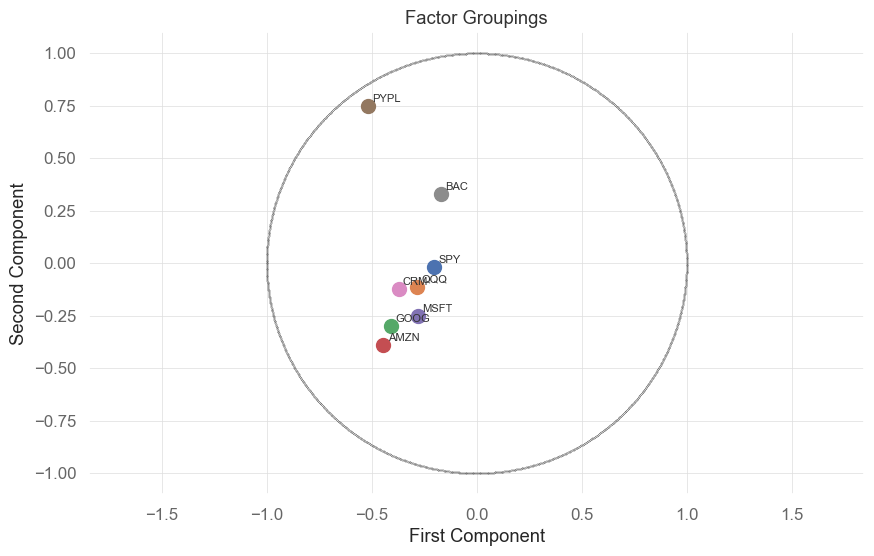

In [42]:
# Run Factor PCA for the below Assets
symbols = ['SPY', 'QQQ', 'GOOG', 'AMZN', 'MSFT', 'PYPL', 'CRM', 'BAC'] 
df = yf.download(symbols, start='2023-1-1', progress=False).Close
plot_assets_by_principal_components(df, symbols, 252)